In [1]:
sample_size_to_animate_on = 5 #this has to be less than or equal to the sample_size
epsilon = 0.1
hypothesis_class_cardinality = 10000
interpolation_mode = "continuous"

highlighted_hypothesis = 5 #[0-7]
find_points = True

In [2]:
data_path = '/content/drive/My Drive/Simulations in Stat learning/data/vc_choreo/'
distributions_path = '/content/drive/My Drive/Simulations in Stat learning/distributions/'
videos_path = '/content/drive/My Drive/Simulations in Stat learning/videos/vc_choreo/'

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib
%matplotlib inline
from scipy.stats import multivariate_normal
import pickle
import os

In [4]:
sample_size = sample_size_to_animate_on
true_unknown_distribution = "circle"
is_agnostic = False
specific_hypothesis = highlighted_hypothesis



In [5]:
np.random.seed(42)
#Standard
plt.rcParams["figure.figsize"] = (24,18)
plt.rcParams['axes.linewidth'] = 7
plt.rcParams['savefig.facecolor']='blue'
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams['xtick.major.pad']='25'
plt.rcParams['ytick.major.pad']='25'

# Supporting Functions

In [6]:
#CUSTOM COLORMAPS

label_colors = matplotlib.colors.ListedColormap(['silver', 'Black'])
right_wrong_colors = matplotlib.colors.ListedColormap(['tomato', 'forestgreen'])
hypothesis_colors = matplotlib.colors.ListedColormap(['tomato', 'silver'])


In [7]:
#norm = colors.Normalize(0, 1)
def get_facecolors(array,mode,alpha = 1):
    shape = array.shape
    p = (-1,)
    if mode == "greenred":
        colors = right_wrong_colors(array.reshape(-1),alpha)
    if mode == "black":
        
        colors = cm.binary(array.reshape(-1),alpha)
        
    return colors.reshape(shape + p)

In [8]:
#This get labels is slightly different from the one in hoeffdings inequality notebook
def get_labels(x,y,distribution):
    if distribution == "circle":
        z = np.where(x**2 + y**2 + 2*0.9*x + 2*0.5*y - 0.2 > 0 , 1 , 0)  
        
    elif distribution == "linear":
        h_labeling = np.array([0.7,0.5])
        
        temp = np.c_[x,y]   #---for animation
        z = np.where(np.matmul(temp,h_labeling) - 0> 0.0, 1, 0)
        
    elif distribution =="wiggly1":
        z = np.where(3*y**3 +x**2 -0.2*y**2 +  0*x - 0.01   >0, 1, 0)
        
    elif distribution =="wiggly2":
        z = np.where(30*x**10 + 2*y**10 -700*x**7 + 20*y**5 -1*x**2 + 0.02   >0, 0, 1)
        
    elif distribution == "l1":
        z1 = np.where(abs(x)+abs(y)>0.15,1,0)
        z2 = np.where(abs(x)+abs(y)>0.4,1,0)

        z = np.logical_xor(z1,z2)
    
    else :
        filename = distributions_path + distribution + ".png"
        im = plt.imread(filename)
        image = np.round(np.sum(im,2)/3)

        x_ = np.floor((x + 0.4)*1000)
        y_ = np.floor((y + 0.4)*1000)

        labels = []
        for i,j in zip(x_.astype(int),y_.astype(int)):

            label = image[i,j]
            labels.append(label)

        z = np.abs(1 - np.array(labels))
    
    
        
    return z

In [9]:
def errors_on_hypothesis_set(data,hypothesis):
    intermediate = np.matmul(data[:,:2], hypothesis)
    predictions = np.where(intermediate > 0.0, 1, 0)
    labels = data[:,2]

    E_out = np.logical_xor(predictions.T,labels)
    true_errors = 1 - np.sum(E_out,axis=1)/E_out.shape[1]
    
    return true_errors,E_out,predictions  #this depends on which all hypothesis I want to animate on

__________________________________________________________________________________________________________________

# All the knobs

In [10]:
#PAC LEARNING
#All the knobs here
n = sample_size_to_animate_on
distribution = true_unknown_distribution
agnostic = is_agnostic
#interpolation_type = 

if agnostic:
  name = "agnostic"
else:
  name = distribution



e = epsilon
vc_dim = 2



#THE HYPOTHESIS SPACE
num_hypothesis = hypothesis_class_cardinality
hypothesis = np.random.uniform(-1,1,[2,num_hypothesis])
h8 = np.array([[0.5,0.5],
               [0.5,0],
               [0.5,-0.5],
               [-0.5,0.5],
               [-0.5,0],
               [-0.5,-0.5],
               [0,0.5],
               [0,-0.5]])
hypothesis[:,:8] = h8.T




data = np.load(data_path  + "data_"+name+'_'+str(40000)+".npy")

if sample_size == 1:
  training_data = np.random.uniform(-0.4,0.4,[1,2])
  training_labels = get_labels(training_data[:,0],training_data[:,1],distribution).astype(int)
  training_data = np.c_[training_data,training_labels]

else:
  training_data = np.load(data_path  + "training_data_"+name+".npy")

  new_point = training_data[np.random.randint(0,training_data.shape[0]),:].reshape(1,3)#np.random.uniform(-0.4,0.4,[1,2])
  #new_point_labels = get_labels(new_point[:,0],new_point[:,1],distribution).astype(int)
  #new_point = np.c_[new_point,new_point_labels]

  
  training_data = np.r_[training_data,new_point]









# do big matrix multiplications


In [11]:

true_errors,E_out,p_true = errors_on_hypothesis_set(data,hypothesis)
in_sample_errors,E_in,_ = errors_on_hypothesis_set(training_data,hypothesis)

In [12]:
h_erm = highlighted_hypothesis#np.argmin(in_sample_errors)  #this is an artifact and confusing

In [13]:
#Taking a slice for the current hypothesis. First 8 are going to be SPECIFIC hypothesis
E_out = E_out[h_erm,:]
p_true = p_true[:,h_erm]

___________________________________________________________________________________________________________________________

# Plotting

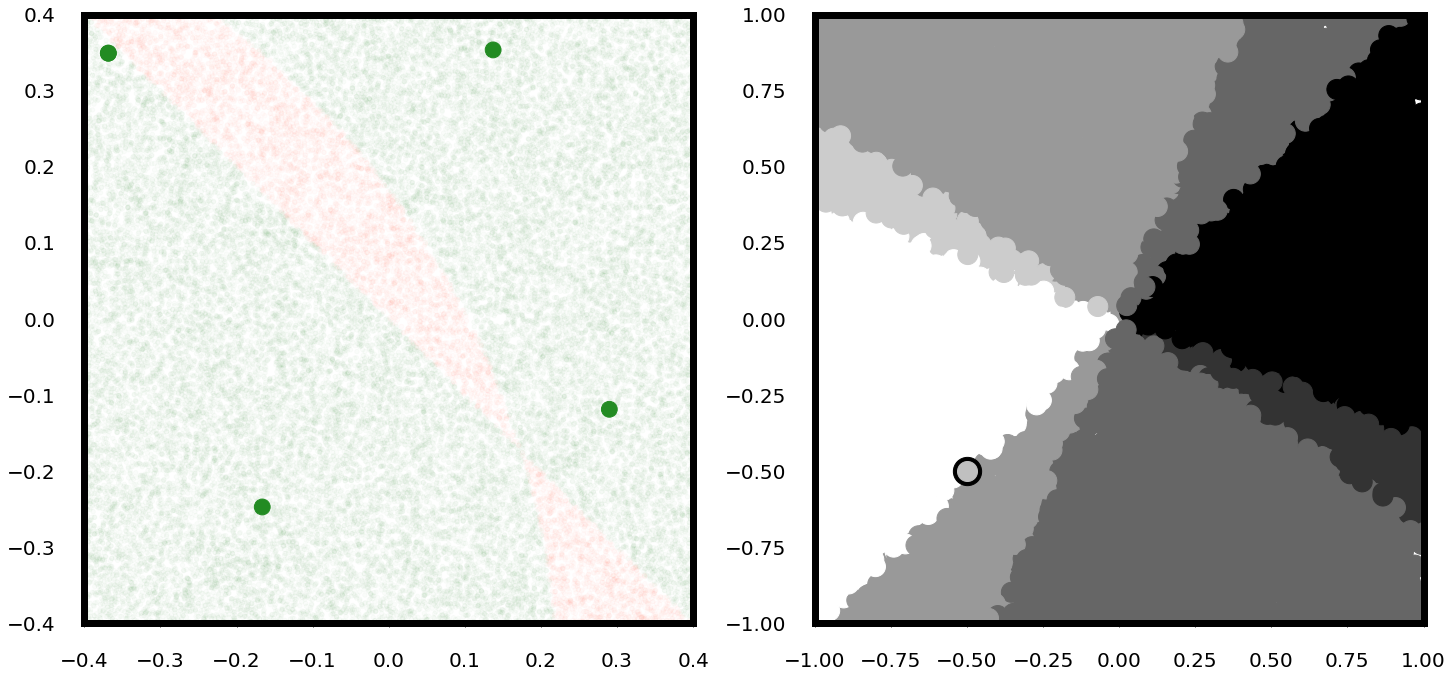

In [14]:
#Formatting the plot
fig, axs = plt.subplots(1, 2)
plt.autoscale(False)

axs[0].set_xlim([-0.4, 0.4])
axs[0].set_ylim([-0.4, 0.4])
axs[0].set_aspect(aspect='equal', adjustable='box')

axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-1, 1])
axs[1].set_aspect(aspect='equal', adjustable='box')






#When animating the hypothesis I need to have a reference over this
axs[0].scatter(data[:,0],data[:,1],c=right_wrong_colors(E_out,0.02),s = 20)# replace 0.02 with 1
sample_space_2  = axs[0].scatter(training_data[:,0],training_data[:,1],c=right_wrong_colors(E_in[h_erm,:],1),s = 250) #animate these

#diff = np.abs(true_errors - in_sample_errors)
#hypothesis_space_2 = axs[1].scatter(hypothesis[0,:],hypothesis[1,:],c = hypothesis_colors(diff<e,1),s=400)

hypothesis_space_2 = axs[1].scatter(hypothesis[0,:],hypothesis[1,:],c = get_facecolors(in_sample_errors,mode="black"),s=400)

#For Animating Current hypothesis
x = hypothesis[0,h_erm]
y = hypothesis[1,h_erm]

current_hypothesis_0 = axs[1].scatter(x,y,s=800,color = 'black')
current_color = axs[1].scatter(x,y,s=400,color = 'silver')




#fig.colorbar(hypothesis_space_0,ax=axs[1],fraction=0.046, pad=0.1)
#fig.colorbar(hypothesis_space_1,ax=axs[2],fraction=0.046, pad=0.1)
#fig.colorbar(hypothesis_space_2,ax=axs[3],fraction=0.046, pad=0.1)



# Can I increase the number of points as they move? Maybe I can have 10 points in the same location and then all the points go their own way.




# Just moving in the sample space

In [15]:
def get_linear_interpolated_points(current_points,final_points,frames):
    shape = current_points.shape
    diff = final_points.reshape(-1) - current_points.reshape(-1)
    offset = diff/frames
    interpolated_points = []
    for i in range(frames):
        points_n = current_points.reshape(-1) + offset*i
        interpolated_points.append(points_n.reshape(shape))
    return np.array(interpolated_points)

In [16]:
training_data[:,:2].shape

(5, 2)

In [17]:
#change this to consider agnostic case

if interpolation_mode == "continuous":

  num_of_samples = 3
  frames_scale = 50 
  frames = frames_scale*num_of_samples




  
  #Sample from the points which are green

  current_points = training_data[:,:2].copy()
  interpolated_points = []
  for i in range(num_of_samples):
      
      #rows = np.random.randint(0,greens_half.shape[0],n)
      final_points = np.random.uniform(-0.4,0.4,[n,2])
      ip = get_linear_interpolated_points(current_points,final_points,frames = frames_scale)
      interpolated_points.append(ip)
      current_points = final_points.copy()
  interpolated_points = np.array(interpolated_points).reshape(-1,n,2)

if interpolation_mode == "iid":
  if find_points == True:
    temp_frames = 100


    iid_samples = np.random.uniform(-0.4,0.4,[temp_frames,n,2])
    interpolation_intermediate = np.matmul(iid_samples,hypothesis)
    interpolation_predictions = np.where(interpolation_intermediate > 0.0, 1, 0)
    interpolation_labels = get_labels(iid_samples[:,:,0].reshape(n*temp_frames),iid_samples[:,:,1].reshape(n*temp_frames),distribution).reshape(temp_frames,-1,1)
    interpolation_in_error =1 - np.sum(np.logical_xor(interpolation_predictions, interpolation_labels),axis=1)/iid_samples.shape[1]
    interpolation_diff = np.abs(interpolation_in_error - true_errors)

    #this works for only 1 hypothesis..make it work for all 8.
    if True:
      how_many_h_red = np.where(interpolation_diff<e*1.5,0,1)
      x = np.sum(how_many_h_red,1)

      red_point_indices = np.where(x > 0)
      white_point_indices = np.where(x == 0)

      white_points = iid_samples[white_point_indices[0][:4],:,:]       ############            NEED MORE RED POINTS?
      red_points = iid_samples[red_point_indices[0][:4],:,:]

      interpolated_points = np.r_[white_points,red_points]
      frames = interpolated_points.shape[0]
      np.save(data_path+"iid_interpolation_"+str(n)+".npy",interpolated_points)



    else:
      white_point_indices = np.where(interpolation_diff<e)
      red_point_indices = np.where(interpolation_diff>e*1.4)
    

      white_points = iid_samples[white_point_indices[0][:4],:,:] ############            NEED MORE RED POINTS?
      red_points = iid_samples[red_point_indices[0][:4],:,:]

      interpolated_points = np.r_[white_points,red_points]

      frames = interpolated_points.shape[0]
      np.save(data_path+"iid_interpolation_"+str(n)+".npy",interpolated_points)


  else:
    interpolated_points = np.load(data_path+"iid_interpolation_"+str(n)+".npy")
    frames = interpolated_points.shape[0]


In [18]:
if interpolation_mode == "continuous":
  fps=30
  interval = 10
else:
  temp = np.broadcast_to(interpolated_points, (10, 8,sample_size_to_animate_on,2))
  interpolated_points = temp.reshape(80,sample_size_to_animate_on,2,order='F')
  frames = interpolated_points.shape[0]

  fps=10
  interval = 1000

In [19]:
last_point = interpolated_points[-1,:,:]
last_point_labels = get_labels(last_point[:,0],last_point[:,1],distribution).astype(int)
last_point = np.c_[last_point,last_point_labels]
np.save(data_path  + "training_data_"+name+".npy",last_point)

# Calculate the facecolors to be used in the animation

In [20]:
#Use lambda here ,as the session crashes

#interpolated points has the shape [frame,n(sample size),2( 2dimensional)]
interpolation_intermediate = np.matmul(interpolated_points,hypothesis)
interpolation_predictions = np.where(interpolation_intermediate > 0.0, 1, 0)

#interpolation_labels = np.where(np.matmul(interpolated_points,labeling_hypothesis) > 0, 1, 0)
interpolation_labels = get_labels(interpolated_points[:,:,0].reshape(n*frames),interpolated_points[:,:,1].reshape(n*frames),distribution).reshape(frames,-1,1)
right_wrong = np.logical_xor(interpolation_labels.reshape(frames,-1),interpolation_predictions[:,:,h_erm])
interpolation_label_facecolors = get_facecolors(right_wrong,mode = "greenred")

interpolation_in_error =1 - np.sum(np.logical_xor(interpolation_predictions, interpolation_labels),axis=1)/interpolated_points.shape[1]
interpolated_in_error_facecolors = get_facecolors(interpolation_in_error,mode="black")

#interpolation_diff = np.abs(interpolation_in_error - true_errors)
#interpolated_facecolors = get_facecolors(interpolation_diff<e,mode="greyred")


# Animation

In [21]:

def animate(i,interpolated_points,interpolated_in_error_facecolors,interpolation_label_facecolors): #interpolated_in_acc_facecolors,
    
    sample_space_2.set_offsets(interpolated_points[i,:,:])
    sample_space_2.set_facecolors(interpolation_label_facecolors[i,:,:])
    
    #hypothesis_space_1.set_facecolors(interpolated_in_error_facecolors[i,:,:])
    
    hypothesis_space_2.set_facecolors(interpolated_in_error_facecolors[i,:,:])
    current_color.set_facecolors(interpolated_in_error_facecolors[i,h_erm,:])
    
    return sample_space_2,hypothesis_space_2,current_color,#hypothesis_space_1,

In [22]:
name = "mDataset_"+name

In [23]:
ani = animation.FuncAnimation(fig, animate, fargs=(interpolated_points,interpolated_in_error_facecolors,interpolation_label_facecolors,),  #interpolated_in_error_facecolors,
            frames=frames, interval=10, repeat=False,blit = True) 

ani.save(videos_path+ name +'_'+str(sample_size_to_animate_on)+'.mp4', fps=30, extra_args=['-vcodec', 'libx264'],savefig_kwargs=dict(facecolor='blue'))